In [1]:
import numpy as np
from scipy.linalg import eigh, qr, null_space
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Sans'
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from scipy.sparse import kron, identity, csr_matrix, csc_matrix, lil_matrix, dok_matrix, issparse, coo_matrix
from scipy.sparse.linalg import eigsh, eigs, norm
from scipy.optimize import curve_fit
from qutip import Qobj, ptrace, entropy_vn, qeye, tensor
from tqdm import tqdm
from itertools import product
from functools import reduce
import torch
import torch.optim as optim
from torch.autograd import Variable
import sympy as sp
from collections import Counter

In [2]:
def pauli_x():
    """Pauli X matrix."""
    return np.array([[0, 1], [1, 0]])

def pauli_z():
    """Pauli Z matrix."""
    return np.array([[1, 0], [0, -1]])

def catalan_bonds(): #14 vertices
    """
    Defines the connectivity of a true 14-vertex Catalan molecular structure.

    Returns:
        list of tuples: Each tuple (i, j) represents a bond between spin i and spin j.
    """
    bonds = [
    (0, 1), (0, 2), (0, 4), (0, 5),
    (1, 3), (1, 6),
    (2, 3), (2, 7),
    (3, 8), (3, 9),
    (4, 6), (4, 10),
    (5, 7), (5, 10),
    (6, 8), (6, 11),
    (7, 9), (7, 12),
    (8, 13),
    (9, 13),
    (10, 11), (10, 12),
    (11, 13),
    (12, 13)
]

    return bonds


def transverse_field_ising_catalan(N, J, h):
    """
    Constructs the Hamiltonian for the transverse field Ising model on a Catalan molecular structure.

    Parameters:
        N (int): Number of spins (should match the Catalan molecule, typically N=14).
        J (float): Interaction strength.
        h (float): Transverse field strength.
    
    Returns:
        H (scipy.sparse.csr_matrix): The Hamiltonian matrix in sparse format.
    """
    if N != 14:
        raise ValueError("Catalan molecules typically have N = 14 sites.")

    # Sparse identity matrix
    I = identity(2, format="csr")
    
    # Pauli matrices as sparse matrices
    X = csr_matrix(pauli_x())
    Z = csr_matrix(pauli_z())
    
    # Initialize the Hamiltonian
    H = csr_matrix((2**N, 2**N), dtype=np.float64)

    # Get Catalan bonds
    bonds = catalan_bonds()

    # Interaction term: J * sigma_i^x * sigma_j^x for Catalan connectivity
    for i, j in bonds:
        term = 1
        for k in range(N):
            if k == i or k == j:
                term = kron(term, X, format="csr")
            else:
                term = kron(term, I, format="csr")
        H += J * term
    
    # Transverse field term: -h * sigma_i^z
    for i in range(N):
        term = 1
        for j in range(N):
            if j == i:
                term = kron(term, Z, format="csr")
            else:
                term = kron(term, I, format="csr")
        H += -h * term
    
    return H

def ising_catalan(N, J):
    """
    Constructs the Hamiltonian for the transverse field Ising model on a Catalan molecular structure without transverse field.

    Parameters:
        N (int): Number of spins (should match the Catalan molecule, typically N=14).
        J (float): Interaction strength.
    
    Returns:
        H (scipy.sparse.csr_matrix): The Hamiltonian matrix in sparse format.
    """
    if N != 14:
        raise ValueError("Catalan molecules typically have N = 14 sites.")

    # Sparse identity matrix
    I = identity(2, format="csr")
    
    # Pauli matrices as sparse matrices
    X = csr_matrix(pauli_x())
    
    # Initialize the Hamiltonian
    H = csr_matrix((2**N, 2**N), dtype=np.float64)

    # Get Catalan bonds
    bonds = catalan_bonds()

    # Interaction term: J * sigma_i^x * sigma_j^x for Catalan connectivity
    for i, j in bonds:
        term = 1
        for k in range(N):
            if k == i or k == j:
                term = kron(term, X, format="csr")
            else:
                term = kron(term, I, format="csr")
        H += J * term
    
    return H

def transverse_field_catalan(N, h):
    """
    Constructs the Hamiltonian for the transverse field Ising model on a Catalan molecular structure.

    Parameters:
        N (int): Number of spins (should match the Catalan molecule, typically N=14).
        J (float): Interaction strength.
        h (float): Transverse field strength.
    
    Returns:
        H (scipy.sparse.csr_matrix): The Hamiltonian matrix in sparse format.
    """
    if N != 14:
        raise ValueError("Catalan molecules typically have N = 14 sites.")

    # Sparse identity matrix
    I = identity(2, format="csr")
    
    # Pauli matrices as sparse matrices
    Z = csr_matrix(pauli_z())
    
    # Initialize the Hamiltonian
    H = csr_matrix((2**N, 2**N), dtype=np.float64)

    # Get Catalan bonds
    bonds = catalan_bonds()

    # Transverse field term: -h * sigma_i^z
    for i in range(N):
        term = 1
        for j in range(N):
            if j == i:
                term = kron(term, Z, format="csr")
            else:
                term = kron(term, I, format="csr")
        H += -h * term
    
    return H

#######################################################################################################################

'''
def partial_trace_qubit(rho, keep, dims):
    """Compute the partial trace of a density matrix of qubits."""
    keep_dims = np.prod([dims[i] for i in keep])
    trace_dims = np.prod([dims[i] for i in range(len(dims)) if i not in keep])
    rho = rho.reshape([keep_dims, trace_dims, keep_dims, trace_dims])
    return np.trace(rho, axis1=1, axis2=3).reshape([keep_dims, keep_dims])

def partial_trace_qubit_torch(rho, keep, dims):
    """Compute the partial trace of a density matrix of qubits using PyTorch."""
    keep_dims = torch.prod(torch.tensor([dims[i] for i in keep]))
    trace_dims = torch.prod(torch.tensor([dims[i] for i in range(len(dims)) if i not in keep]))
    rho = rho.view(keep_dims, trace_dims, keep_dims, trace_dims)
    # Compute the partial trace
    traced_rho = torch.zeros((keep_dims, keep_dims), dtype=rho.dtype)
    for i in range(trace_dims):
        traced_rho += rho[:, i, :, i]
    #return traced_rho.view(keep_dims, keep_dims)
    return traced_rho'''

def isket_numpy(arr):
    """
    Check if a NumPy array is a ket (column vector).

    Parameters:
    - arr: np.ndarray, the array to check.

    Returns:
    - bool, True if the array is a ket, False otherwise.
    """
    if not isinstance(arr, np.ndarray):
        raise ValueError("Input must be a NumPy array")

    shape = arr.shape

    if len(shape) == 2 and shape[1] == 1:
        return True
    else:
        return False

def ptrace_numpy(Q, sel, dims): # numpy function adapted from ptrace of qutip
    """
    Compute the partial trace of a density matrix of qubits using NumPy.

    Parameters:
    - Q: numpy object, the quantum object (density matrix or state vector).
    - sel: list of int, indices of the subsystems to keep.
    - dims: list of int, dimensions of the subsystems.

    Returns:
    - numpy object, the reduced density matrix after tracing out the specified subsystems.
    """
    # Get the dimensions of the subsystems
    rd = np.asarray(dims[0], dtype=np.int32).ravel()
    nd = len(rd)
    
    # Ensure sel is a sorted array of indices
    if isinstance(sel, int):
        sel = np.array([sel])
    else:
        sel = np.asarray(sel)
    sel = list(np.sort(sel))
    
    # Dimensions of the subsystems to keep
    dkeep = (rd[sel]).tolist()
    
    # Indices of the subsystems to trace out
    qtrace = list(set(np.arange(nd)) - set(sel))
    
    # Dimensions of the subsystems to trace out
    dtrace = (rd[qtrace]).tolist()
    
    # Reshape the density matrix or state vector
    rd = list(rd)
    if isket_numpy(Q):
        # Reshape and transpose for state vector
        vmat = (Q
                .reshape(rd)
                .transpose(sel + qtrace)
                .reshape([np.prod(dkeep), np.prod(dtrace)]))
        # Compute the reduced density matrix
        rhomat = vmat.dot(vmat.conj().T)
    else:
        # Reshape and transpose for density matrix
        rhomat = np.trace(Q
                          .reshape(rd + rd)
                          .transpose(qtrace + [nd + q for q in qtrace] +
                                     sel + [nd + q for q in sel])
                          .reshape([np.prod(dtrace),
                                    np.prod(dtrace),
                                    np.prod(dkeep),
                                    np.prod(dkeep)]))
    return rhomat


def ptrace_sparse(psi_sparse, keep, dims):
    """
    Compute the partial trace over arbitrary subsystems using sparse matrix operations.

    Args:
        psi_sparse (scipy.sparse matrix): Full density matrix of shape (D, D), where D = product(dims)
        keep (list of int): Subsystems to keep (indices, 0-indexed)
        dims (list of int): List of subsystem dimensions, e.g., [2]*n for n qubits

    Returns:
        scipy.sparse.csr_matrix: Reduced density matrix over kept subsystems
    """
    if not issparse(psi_sparse):
        raise ValueError("psi_sparse must be a scipy.sparse matrix")
    n = len(dims)
    D = np.prod(dims)
    if psi_sparse.shape != (D, D):
        raise ValueError("Density matrix shape does not match dims")
    trace = [i for i in range(n) if i not in keep]
    d_keep = np.prod([dims[i] for i in keep])
    # Prepare output
    data = []
    row_idx = []
    col_idx = []

    # Precompute bit masks
    def idx_to_bits(idx):
        return np.array(list(np.binary_repr(idx, width=n))).astype(int)
    

    psi_sparse = psi_sparse.tocoo()
    for i, j, val in zip(psi_sparse.row, psi_sparse.col, psi_sparse.data):
        bi = idx_to_bits(i)
        bj = idx_to_bits(j)


        # Only sum terms where traced-out subsystems agree
        if np.all(bi[trace] == bj[trace]):
            # Extract kept bits and convert to reduced indices
            #print('condition met for i, j:', i, j)
            i_red_bits = bi[keep]
            j_red_bits = bj[keep]
            i_red = int("".join(i_red_bits.astype(str)), 2)
            j_red = int("".join(j_red_bits.astype(str)), 2)


            data.append(val)
            row_idx.append(i_red)
            col_idx.append(j_red)
    
    return coo_matrix((data, (row_idx, col_idx)), shape=(d_keep, d_keep)).tocsr()


def isket_torch(arr):
    """
    Check if a PyTorch tensor is a ket (column vector).

    Parameters:
    - arr: torch.Tensor, the array to check.

    Returns:
    - bool, True if the array is a ket, False otherwise.
    """
    if not isinstance(arr, torch.Tensor):
        raise ValueError("Input must be a PyTorch tensor")

    shape = arr.shape

    if len(shape) == 2 and shape[1] == 1:
        return True
    else:
        return False

def ptrace_torch(Q, sel, dims): # torch function adapted from ptrace of qutip
    """
    Compute the partial trace of a density matrix of qubits using PyTorch.

    Parameters:
    - Q: torch.Tensor, the quantum object (density matrix or state vector).
    - sel: list of int, indices of the subsystems to keep.
    - dims: list of int, dimensions of the subsystems.

    Returns:
    - torch.Tensor, the reduced density matrix after tracing out the specified subsystems.
    """
    # Get the dimensions of the subsystems
    rd = torch.tensor(dims[0], dtype=torch.int32).flatten()
    nd = len(rd)
    #print("rd", rd)
    #print("nd", nd)
    
    # Ensure sel is a sorted array of indices
    if isinstance(sel, int):
        sel = torch.tensor([sel])
    else:
        sel = torch.tensor(sel)
    sel = torch.sort(sel).values.tolist()
    
    # Dimensions of the subsystems to keep
    dkeep = rd[sel].tolist()
    
    # Indices of the subsystems to trace out
    qtrace = list(set(range(nd)) - set(sel))
    
    # Dimensions of the subsystems to trace out
    dtrace = rd[qtrace].tolist()
    
    # Reshape the density matrix or state vector
    rd = rd.tolist()
    if isket_torch(Q):
        # Reshape and transpose for state vector
        reshaped_Q = Q.reshape(rd)
        #print(reshaped_Q.shape)
        transposed_Q = reshaped_Q.permute(sel + qtrace)
        #print(transposed_Q.shape)
        vmat = transposed_Q.reshape([torch.prod(torch.tensor(dkeep)), torch.prod(torch.tensor(dtrace))])
        #print(vmat.shape)
        # Compute the reduced density matrix
        rhomat = vmat @ vmat.conj().T
        #print(rhomat.shape)
    else:
        # Reshape and transpose for density matrix
        reshaped_Q = Q.reshape(rd + rd)
        #print("reshaped_Q", reshaped_Q.shape)
        transposed_Q = reshaped_Q.permute(qtrace + [nd + q for q in qtrace] + sel + [nd + q for q in sel])
        #print("transposed_Q", transposed_Q.shape)
        reshaped_transposed_Q = transposed_Q.reshape([torch.prod(torch.tensor(dtrace)), torch.prod(torch.tensor(dtrace)), torch.prod(torch.tensor(dkeep)), torch.prod(torch.tensor(dkeep))])
        #print("reshaped_transposed_Q", reshaped_transposed_Q.shape)
        #rhomat = torch.trace(reshaped_transposed_Q)
        rhomat = torch.einsum('iikl->kl', reshaped_transposed_Q)
        # Trace out the first two dimensions
        #rhomat = torch.zeros((torch.prod(torch.tensor(dkeep)), torch.prod(torch.tensor(dkeep))), dtype=Q.dtype)
        #for i in range(reshaped_transposed_Q.shape[0]):
        #    for j in range(reshaped_transposed_Q.shape[1]):
        #        rhomat += reshaped_transposed_Q[i, j, :, :]
        #print("rhomat", rhomat.shape)
    return rhomat

def entanglement_entropy(psi, subsystem, total_size):

    '''Computes the bipartite entanglement entropy of a pure state.
    
    Parameters:
    psi : np.array
        The wavefunction (state vector) of the full system.
    subsystem_size : int
        The number of qubits in subsystem A.
    total_size : int
        The total number of qubits in the system.
    
    Returns:
    float
        The von Neumann entanglement entropy S_A.'''
    
    psi_matrix =  np.outer(psi, psi.conj())

    # Compute the reduced density matrix rho_A = Tr_B(|psi><psi|)
    rho_A = ptrace_numpy(psi_matrix, subsystem, [[2]*total_size, [2]*total_size])  # Partial trace over B
    
    # Compute eigenvalues of rho_A
    eigenvalues = np.linalg.eigvalsh(rho_A)
    
    # Filter out zero eigenvalues to avoid numerical issues in log calculation
    eigenvalues = eigenvalues[eigenvalues > 0]
    
    # Compute von Neumann entropy S_A = -Tr(rho_A log rho_A)
    entropy = -np.sum(eigenvalues * np.log2(eigenvalues))
    
    return entropy

def entanglement_entropy_torch(psi, subsystem, total_size):
    """
    Computes the bipartite entanglement entropy of a pure state using PyTorch.

    Parameters:
    - psi: torch.Tensor (complex), the wavefunction (state vector) of the full system.
    - subsystem_size: int, the number of qubits in subsystem A.
    - total_size: int, the total number of qubits in the system.

    Returns:
    - torch.Tensor (scalar), the von Neumann entanglement entropy S_A.
    """

    if not isinstance(psi, torch.Tensor):
        psi = torch.tensor(psi, dtype=torch.complex64)
    
    # Ensure psi is normalized
    psi = psi / torch.norm(psi)

    # Compute the density matrix |psi><psi|
    psi_matrix = torch.outer(psi, psi.conj())

    # Compute the reduced density matrix rho_A = Tr_B(|psi><psi|)
    rho_A = ptrace_torch(psi_matrix, subsystem, [[2] * total_size, [2] * total_size])  # Partial trace over B

    #rho_A = rho_A.to(dtype=torch.float64)
    
    # Compute eigenvalues of rho_A
    eigvals = torch.linalg.eigvalsh(rho_A)

    # Filter out zero eigenvalues to avoid numerical issues in log calculation
    eigvals = eigvals[eigvals > 0]

    # Compute von Neumann entropy S_A = -Tr(rho_A log rho_A)
    entropy = -torch.sum(eigvals * torch.log2(eigvals))

    return entropy

def entanglement_entropy_qutip(psi, subsystem, total_size):
    
    # Convert the wavefunction to a QuTiP Qobj
    density_matrix = np.outer(psi, psi.conj())
    density_matrix_qobj = Qobj(density_matrix, dims=[[2]*total_size, [2]*total_size])

    rho_A = ptrace(density_matrix_qobj, subsystem)
    # Compute the von Neumann entropy S_A
    entropy = entropy_vn(rho_A, base=2)
    
    return entropy

def entanglement_entropy_np_ptrace(rdm):
    # rdm already computed and converted to numpy
    # Compute eigenvalues of rho_A
    eigenvalues = np.linalg.eigvalsh(rdm)
    
    # Filter out zero eigenvalues to avoid numerical issues in log calculation
    eigenvalues = eigenvalues[eigenvalues > 0]
    
    # Compute von Neumann entropy S_A = -Tr(rho_A log rho_A)
    entropy = -np.sum(eigenvalues * np.log2(eigenvalues))
    
    return entropy

def entanglement_entropy_torch_ptrace(rdm):

    eigvals = torch.linalg.eigvalsh(rdm)
    eigvals = eigvals[eigvals > 0]
    entropy = -torch.sum(eigvals * torch.log2(eigvals))
    return entropy


def entanglement_entropy_qutip_torch(psi, N):
    """
    Compute the von Neumann entanglement entropy using qutip.

    Parameters:
    - psi: torch.Tensor (complex), state vector of a quantum system.
    - N: int, total number of qubits.

    Returns:
    - torch.Tensor (scalar), von Neumann entropy.
    """
    # Ensure psi is normalized
    psi = psi / torch.norm(psi)

    # Convert PyTorch tensor to NumPy for QuTiP
    psi_np = psi.detach().numpy()

    rho_np = np.outer(psi_np, psi_np.conj())
    rho_qobj = Qobj(rho_np, dims=[[2] * N, [2] * N])

    rho_A = ptrace(rho_qobj, list(range(N // 2)))

    # Compute von Neumann entropy
    entropy = entropy_vn(rho_A, base=2)  # Compute in log base 2

    # Convert back to PyTorch tensor to allow gradient flow
    return torch.tensor(entropy, dtype=torch.float32, requires_grad=True)

#######################################################################################################################

# Define the linear combination function - numpy
def linear_combination_np(coeffs, psis):
    # Ensure psis are numpy tensors
    psi_np = [np.array(psi) for psi in psis]
    # Compute the linear combination in PyTorch
    psi = sum(c * psi for c, psi in zip(coeffs, psis))
    
    return psi

# Define the linear combination function - torch
def linear_combination(coeffs, psis):
    # Ensure psis are PyTorch tensors
    psis_torch = [torch.tensor(psi, dtype=torch.complex64) if not isinstance(psi, torch.Tensor) else psi for psi in psis]
    
    # Compute the linear combination in PyTorch
    psi_torch = sum(c * psi for c, psi in zip(coeffs, psis_torch))
    
    return psi_torch

# Define the linear combination function - torch but after computing the ptrace of outer products of scars
def linear_combination_outer(coeffs, outs):
    # Ensure outs are PyTorch tensors
    outs_torch = [torch.tensor(out, dtype=torch.complex64) if not isinstance(out, torch.Tensor) else out for out in outs]
    torch_coeffs = torch.tensor(coeffs, dtype=torch.complex64)

    # Compute the PyTorch tensor of out_coeffs which is the product of all possible combinations of c_i^* times c_j
    out_coeffs = torch.zeros((len(torch_coeffs), len(torch_coeffs)), dtype=torch.complex64)
    for i in range(len(torch_coeffs)):
        for j in range(len(torch_coeffs)):
            out_coeffs[i, j] = torch.conj(torch_coeffs[i]) * torch_coeffs[j]
    
    # Compute the linear combination in PyTorch
    lin_torch = sum(out_coeffs[i, j] * outs_torch[i] for i in range(len(coeffs)) for j in range(len(coeffs)))
    
    return lin_torch

######################################################

# Function to apply permutation to a given spin configuration
def apply_permutation(state_bits, N, perm):
    new_bits = [0] * N
    for i in range(N):
        new_bits[perm[i]] = state_bits[i]  # Map value at index i to perm[i]
    return new_bits

# Function to convert an index to its binary representation
def index_to_binary(index, num_qubits):
    return format(index, f'0{num_qubits}b')

In [13]:
N = 14  # Number of spins
J = 1.0  # Interaction strength
h = 3.0  # Transverse field strength # this is the value in the paper. maybe try  other values too, including the critical value one (h=J=1)

keep_qubits = [0,2,3,4,6] #4: [0,1,2,3], #5: [0,2,3,4,6], #6: [0,1,2,3,4,6]

trace_qubits = [i for i in range(N) if i not in keep_qubits]


# Assuming transverse_field_ising is defined and returns a sparse Hermitian matrix
H = transverse_field_ising_catalan(N, J, h)
Hi = ising_catalan(N, J)
Htf = transverse_field_catalan(N, h)

#print(f"Hamiltonian shape: {H.shape}")
#print(f"Non-zero elements in H: {H.nnz}")

In [4]:
# All eigenvalues of H
# Compute all eigenvalues and corresponding eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(H.toarray())

print(f"Eigenvalues of H: {np.sort(eigenvalues)}")

# Count the number of (near-)zero components in each eigenvector
zero_threshold = 1e-6
nzero_counts = []
for i in range(eigenvectors.shape[1]):
    num_nzeros = np.sum(np.abs(eigenvectors[:, i]) > zero_threshold)
    nzero_counts.append(num_nzeros)
    print(f"Eigenvector {i}, eigenvalue {eigenvalues[i]}: {num_nzeros} components > {zero_threshold}")

# Optionally, print a summary
print("Zero count distribution:", Counter(nzero_counts))

Eigenvalues of H: [-44.28552356 -42.34934862 -39.68683606 ...  39.68683606  42.34934862
  44.28552356]
Eigenvector 0, eigenvalue -44.28552355759499: 8192 components > 1e-06
Eigenvector 1, eigenvalue -42.34934861506797: 8192 components > 1e-06
Eigenvector 2, eigenvalue -39.686836059301854: 7962 components > 1e-06
Eigenvector 3, eigenvalue -39.68683605930183: 8004 components > 1e-06
Eigenvector 4, eigenvalue -39.68683605930181: 7992 components > 1e-06
Eigenvector 5, eigenvalue -39.192004254555826: 8192 components > 1e-06
Eigenvector 6, eigenvalue -37.671850148668035: 8038 components > 1e-06
Eigenvector 7, eigenvalue -37.671850148668014: 7994 components > 1e-06
Eigenvector 8, eigenvalue -37.671850148668014: 8026 components > 1e-06
Eigenvector 9, eigenvalue -37.668544605479156: 7488 components > 1e-06
Eigenvector 10, eigenvalue -37.50932625247525: 7832 components > 1e-06
Eigenvector 11, eigenvalue -37.509326252475205: 7648 components > 1e-06
Eigenvector 12, eigenvalue -36.47191349997749: 7

In [19]:
# All eigenvalues of Hi
# Compute all eigenvalues and corresponding eigenvectors
eigenvalues_i, eigenvectors_i = np.linalg.eigh(Hi.toarray())

print(f"Eigenvalues of Hi: {np.sort(eigenvalues_i)}")

# Count the number of (near-)zero components in each eigenvector
zero_threshold = 1e-6
nzero_counts_i = []
for i in range(eigenvectors_i.shape[1]):
    num_nzeros = np.sum(np.abs(eigenvectors_i[:, i]) > zero_threshold)
    nzero_counts_i.append(num_nzeros)
    print(f"Eigenvector {i}, eigenvalue {eigenvalues_i[i]}: {num_nzeros} components > {zero_threshold}")

# Optionally, print a summary
print("Zero count distribution:", Counter(nzero_counts_i))

Eigenvalues of Hi: [-24. -24. -18. ...  18.  24.  24.]
Eigenvector 0, eigenvalue -24.000000000000018: 8192 components > 1e-06
Eigenvector 1, eigenvalue -23.99999999999999: 8192 components > 1e-06
Eigenvector 2, eigenvalue -18.000000000000018: 16256 components > 1e-06
Eigenvector 3, eigenvalue -18.00000000000001: 16320 components > 1e-06
Eigenvector 4, eigenvalue -18.000000000000007: 16320 components > 1e-06
Eigenvector 5, eigenvalue -18.000000000000004: 16320 components > 1e-06
Eigenvector 6, eigenvalue -18.000000000000004: 16320 components > 1e-06
Eigenvector 7, eigenvalue -18.0: 16320 components > 1e-06
Eigenvector 8, eigenvalue -18.0: 5952 components > 1e-06
Eigenvector 9, eigenvalue -17.999999999999996: 16320 components > 1e-06
Eigenvector 10, eigenvalue -17.99999999999999: 16320 components > 1e-06
Eigenvector 11, eigenvalue -17.99999999999999: 16256 components > 1e-06
Eigenvector 12, eigenvalue -17.999999999999986: 16320 components > 1e-06
Eigenvector 13, eigenvalue -17.9999999999

In [ ]:
# All eigenvalues of Htf
# Compute all eigenvalues and corresponding eigenvectors
eigenvalues_tf, eigenvectors_tf = np.linalg.eigh(Htf.toarray())

print(f"Eigenvalues of Htf: {np.sort(eigenvalues_tf)}")

# Count the number of (near-)zero components in each eigenvector
zero_threshold = 1e-6
nzero_counts_tf = []
for i in range(eigenvectors_tf.shape[1]):
    num_nzeros = np.sum(np.abs(eigenvectors_tf[:, i]) > zero_threshold)
    nzero_counts_tf.append(num_nzeros)
    print(f"Eigenvector {i}, eigenvalue {eigenvalues_tf[i]}: {num_nzeros} components > {zero_threshold}")

# Optionally, print a summary
print("Zero count distribution:", Counter(nzero_counts_tf))

Indices of (near-)zero eigenvalues of Hi: 6604 to 9779 (total: 3176)
Eigenvalues of Htf in the zero-eigenvalue subspace of Hi: [-6. -6. -6. ...  6.  6.  6.]
eigvecs_sub[0]: 256 components > 1e-06, eigenvalue: -6.0000000000000115
eigvecs_sub[1]: 256 components > 1e-06, eigenvalue: -6.000000000000005
eigvecs_sub[2]: 256 components > 1e-06, eigenvalue: -6.000000000000001
eigvecs_sub[3]: 256 components > 1e-06, eigenvalue: -5.999999999999998
eigvecs_sub[4]: 256 components > 1e-06, eigenvalue: -5.999999999999997
eigvecs_sub[5]: 256 components > 1e-06, eigenvalue: -5.999999999999997
eigvecs_sub[6]: 256 components > 1e-06, eigenvalue: -5.999999999999995
eigvecs_sub[7]: 256 components > 1e-06, eigenvalue: -5.999999999999985
eigvecs_sub[8]: 2560 components > 1e-06, eigenvalue: -4.00000000000001
eigvecs_sub[9]: 2560 components > 1e-06, eigenvalue: -4.000000000000009
eigvecs_sub[10]: 2560 components > 1e-06, eigenvalue: -4.000000000000008
eigvecs_sub[11]: 2560 components > 1e-06, eigenvalue: -4.0

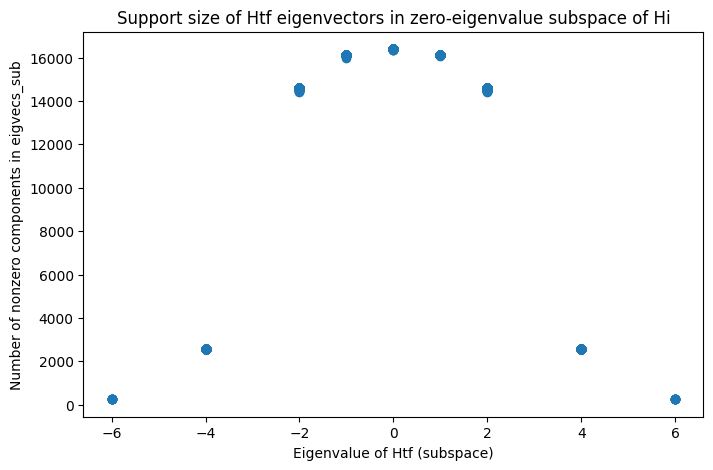

In [23]:
# Step 1: Use the known zero indices range
zero_indices = list(range(6604, 9780))  # 9780 is exclusive, so this includes 9779

print(f"Indices of (near-)zero eigenvalues of Hi: {zero_indices[0]} to {zero_indices[-1]} (total: {len(zero_indices)})")

# Step 2: Form the subspace basis
subspace_basis = eigenvectors_i[:, zero_indices]  # Each column is a basis vector

# Step 3: Project Htf into this subspace
Htf_dense = Htf.toarray()
Htf_subspace = subspace_basis.T @ Htf_dense @ subspace_basis

# Step 4: Diagonalize the projected Htf
eigvals_sub, eigvecs_sub = np.linalg.eigh(Htf_subspace)

print("Eigenvalues of Htf in the zero-eigenvalue subspace of Hi:", eigvals_sub)

# Print and plot number of nonzero components in each eigenvector of the subspace
nnz_threshold = 1e-6
nnz_counts = []
nnz_small = []
for i in range(eigvecs_sub.shape[1]):
    full_vec = subspace_basis @ eigvecs_sub[:, i]
    nnz = np.sum(np.abs(full_vec) > nnz_threshold)
    nnz_counts.append(nnz)
    if nnz < 4000:
        nnz_small.append(i)
        print(f"eigvecs_sub[{i}]: {nnz} components > {nnz_threshold}, eigenvalue: {eigvals_sub[i]}")

print(len(nnz_small), "eigenvectors in the subspace have less than 4000 nonzero components.")
# Plot number of nonzero components vs corresponding eigenvalue
plt.figure(figsize=(8, 5))
plt.plot(eigvals_sub, nnz_counts, 'o')
plt.xlabel("Eigenvalue of Htf (subspace)")
plt.ylabel("Number of nonzero components in eigvecs_sub")
plt.title("Support size of Htf eigenvectors in zero-eigenvalue subspace of Hi")
plt.show()

Eigenvector 2736 with eigenvalue -12.000000000000002 has 96 non-zero components.
Eigenvector 2737 with eigenvalue -12.000000000000002 has 96 non-zero components.
Eigenvector 2738 with eigenvalue -12.0 has 96 non-zero components.
Eigenvector 5157 with eigenvalue -6.000000000000005 has 432 non-zero components.
Eigenvector 5158 with eigenvalue -6.000000000000005 has 432 non-zero components.
Eigenvector 5159 with eigenvalue -6.000000000000004 has 432 non-zero components.
Eigenvector 5160 with eigenvalue -6.000000000000004 has 432 non-zero components.
Eigenvector 5161 with eigenvalue -6.000000000000002 has 432 non-zero components.
Eigenvector 5162 with eigenvalue -6.000000000000002 has 432 non-zero components.
Eigenvector 5163 with eigenvalue -6.000000000000002 has 432 non-zero components.
Eigenvector 5164 with eigenvalue -6.000000000000001 has 432 non-zero components.
Eigenvector 5165 with eigenvalue -6.000000000000001 has 432 non-zero components.
Eigenvector 5166 with eigenvalue -6.000000

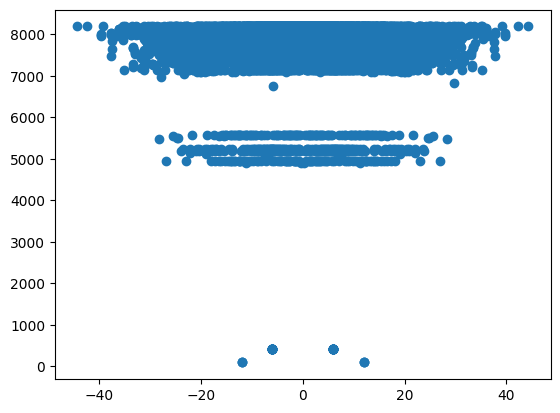

In [6]:
sparse_indices = []
for i in range(eigenvectors.shape[1]):
    if nzero_counts[i] < 2000:
        print(f"Eigenvector {i} with eigenvalue {eigenvalues[i]} has {nzero_counts[i]} non-zero components.")
        sparse_indices.append(i)

print("Indices of sparse eigenvectors:", sparse_indices)

plt.plot(eigenvalues, nzero_counts, 'o')
plt.show()

In [7]:
red_indices = sparse_indices
print(len(red_indices), "scarred states found at indices:", red_indices)

42 scarred states found at indices: [2736, 2737, 2738, 5157, 5158, 5159, 5160, 5161, 5162, 5163, 5164, 5165, 5166, 5167, 5168, 5169, 5170, 5171, 5172, 5173, 5174, 11209, 11210, 11211, 11212, 11213, 11214, 11215, 11216, 11217, 11218, 11219, 11220, 11221, 11222, 11223, 11224, 11225, 11226, 13645, 13646, 13647]


In [ ]:
##################### RDMS + EE #################################

In [ ]:
# scars + tf field - sparse

for i in tqdm(red_indices):
    # Construct the density matrix for each eigenvector (as sparse)
    min_eigenvector = eigenvectors[:, i]
    print("Nonzero elements in state vector (tol=1e-12):", np.sum(np.abs(min_eigenvector) > 1e-6))
    min_eigenvector[np.abs(min_eigenvector) < 1e-7] = 0
    min_eig_sparse = csr_matrix(min_eigenvector.reshape(-1, 1))  # Convert to sparse column vector
    
    # Apply the transverse field operator to the sparse vector
    vecs = transverse_field_catalan(N, J) @ min_eig_sparse
    vecs = vecs.toarray()  # Convert to dense array for further processing

    # Print information about the result
    print(f"for {i}-th eigenvector: Number of nonzero elements in result: {np.count_nonzero(vecs)}")
    print(f"Max absolute value in result: {np.max(np.abs(vecs))}")

  0%|          | 0/42 [00:00<?, ?it/s]

Nonzero elements in state vector (tol=1e-12): 96


  5%|▍         | 2/42 [00:00<00:07,  5.60it/s]

for 2736-th eigenvector: Number of nonzero elements in result: 96
Max absolute value in result: 0.7070563786236888
Nonzero elements in state vector (tol=1e-12): 96
for 2737-th eigenvector: Number of nonzero elements in result: 96
Max absolute value in result: 0.7070860345152858
Nonzero elements in state vector (tol=1e-12): 96


 10%|▉         | 4/42 [00:00<00:06,  6.12it/s]

for 2738-th eigenvector: Number of nonzero elements in result: 96
Max absolute value in result: 0.707036838149793
Nonzero elements in state vector (tol=1e-12): 432
for 5157-th eigenvector: Number of nonzero elements in result: 432
Max absolute value in result: 0.23510090994741217
Nonzero elements in state vector (tol=1e-12): 432


 14%|█▍        | 6/42 [00:00<00:05,  6.59it/s]

for 5158-th eigenvector: Number of nonzero elements in result: 432
Max absolute value in result: 0.19382280275232233
Nonzero elements in state vector (tol=1e-12): 432
for 5159-th eigenvector: Number of nonzero elements in result: 432
Max absolute value in result: 0.25740244122218087
Nonzero elements in state vector (tol=1e-12): 432
for 5160-th eigenvector: Number of nonzero elements in result: 432
Max absolute value in result: 0.276768530491668
Nonzero elements in state vector (tol=1e-12): 432


 21%|██▏       | 9/42 [00:01<00:05,  5.99it/s]

for 5161-th eigenvector: Number of nonzero elements in result: 432
Max absolute value in result: 0.25783768094767484
Nonzero elements in state vector (tol=1e-12): 432
for 5162-th eigenvector: Number of nonzero elements in result: 432
Max absolute value in result: 0.2352283753419574
Nonzero elements in state vector (tol=1e-12): 432


 26%|██▌       | 11/42 [00:01<00:05,  5.94it/s]

for 5163-th eigenvector: Number of nonzero elements in result: 432
Max absolute value in result: 0.2556510550136766
Nonzero elements in state vector (tol=1e-12): 432
for 5164-th eigenvector: Number of nonzero elements in result: 432
Max absolute value in result: 0.27834810498053153


 29%|██▊       | 12/42 [00:02<00:04,  6.03it/s]

Nonzero elements in state vector (tol=1e-12): 432
for 5165-th eigenvector: Number of nonzero elements in result: 432
Max absolute value in result: 0.2290046273580378
Nonzero elements in state vector (tol=1e-12): 432


 33%|███▎      | 14/42 [00:02<00:03,  7.06it/s]

for 5166-th eigenvector: Number of nonzero elements in result: 432
Max absolute value in result: 0.20835415908605875
Nonzero elements in state vector (tol=1e-12): 432
for 5167-th eigenvector: Number of nonzero elements in result: 432
Max absolute value in result: 0.304283971517958
Nonzero elements in state vector (tol=1e-12): 432


 38%|███▊      | 16/42 [00:02<00:03,  7.34it/s]

for 5168-th eigenvector: Number of nonzero elements in result: 432
Max absolute value in result: 0.24161131033876393
Nonzero elements in state vector (tol=1e-12): 432
for 5169-th eigenvector: Number of nonzero elements in result: 432
Max absolute value in result: 0.30269913026595363
Nonzero elements in state vector (tol=1e-12): 432


 43%|████▎     | 18/42 [00:02<00:03,  6.55it/s]

for 5170-th eigenvector: Number of nonzero elements in result: 432
Max absolute value in result: 0.22092392024958493
Nonzero elements in state vector (tol=1e-12): 432
for 5171-th eigenvector: Number of nonzero elements in result: 432
Max absolute value in result: 0.28881049419648297
Nonzero elements in state vector (tol=1e-12): 432


 48%|████▊     | 20/42 [00:03<00:03,  7.01it/s]

for 5172-th eigenvector: Number of nonzero elements in result: 432
Max absolute value in result: 0.2313925631935836
Nonzero elements in state vector (tol=1e-12): 432
for 5173-th eigenvector: Number of nonzero elements in result: 432
Max absolute value in result: 0.20891234036862777
Nonzero elements in state vector (tol=1e-12): 432


 52%|█████▏    | 22/42 [00:03<00:02,  6.98it/s]

for 5174-th eigenvector: Number of nonzero elements in result: 432
Max absolute value in result: 0.22722175091921515
Nonzero elements in state vector (tol=1e-12): 432
for 11209-th eigenvector: Number of nonzero elements in result: 432
Max absolute value in result: 0.19716535470522975
Nonzero elements in state vector (tol=1e-12): 432


 55%|█████▍    | 23/42 [00:03<00:02,  7.04it/s]

for 11210-th eigenvector: Number of nonzero elements in result: 432
Max absolute value in result: 0.24078862515443702
Nonzero elements in state vector (tol=1e-12): 432


 60%|█████▉    | 25/42 [00:03<00:02,  6.24it/s]

for 11211-th eigenvector: Number of nonzero elements in result: 432
Max absolute value in result: 0.2796167218274625
Nonzero elements in state vector (tol=1e-12): 432
for 11212-th eigenvector: Number of nonzero elements in result: 432
Max absolute value in result: 0.2904146790114898
Nonzero elements in state vector (tol=1e-12): 432


 64%|██████▍   | 27/42 [00:04<00:02,  6.36it/s]

for 11213-th eigenvector: Number of nonzero elements in result: 432
Max absolute value in result: 0.20523271305268856
Nonzero elements in state vector (tol=1e-12): 432
for 11214-th eigenvector: Number of nonzero elements in result: 432
Max absolute value in result: 0.25835180610786235
Nonzero elements in state vector (tol=1e-12): 432


 71%|███████▏  | 30/42 [00:04<00:01,  8.05it/s]

for 11215-th eigenvector: Number of nonzero elements in result: 432
Max absolute value in result: 0.282710556926201
Nonzero elements in state vector (tol=1e-12): 432
for 11216-th eigenvector: Number of nonzero elements in result: 432
Max absolute value in result: 0.21074527770715254
Nonzero elements in state vector (tol=1e-12): 432
for 11217-th eigenvector: Number of nonzero elements in result: 432
Max absolute value in result: 0.29904542216773
Nonzero elements in state vector (tol=1e-12): 432


 76%|███████▌  | 32/42 [00:04<00:01,  7.94it/s]

for 11218-th eigenvector: Number of nonzero elements in result: 432
Max absolute value in result: 0.27687471531791374
Nonzero elements in state vector (tol=1e-12): 432
for 11219-th eigenvector: Number of nonzero elements in result: 432
Max absolute value in result: 0.2229815880860904
Nonzero elements in state vector (tol=1e-12): 432


 81%|████████  | 34/42 [00:05<00:01,  6.36it/s]

for 11220-th eigenvector: Number of nonzero elements in result: 432
Max absolute value in result: 0.20194946041600373
Nonzero elements in state vector (tol=1e-12): 432
for 11221-th eigenvector: Number of nonzero elements in result: 432
Max absolute value in result: 0.2669695879867799


 83%|████████▎ | 35/42 [00:05<00:01,  6.24it/s]

Nonzero elements in state vector (tol=1e-12): 432
for 11222-th eigenvector: Number of nonzero elements in result: 432
Max absolute value in result: 0.24043034210471492
Nonzero elements in state vector (tol=1e-12): 432


 88%|████████▊ | 37/42 [00:05<00:00,  6.84it/s]

for 11223-th eigenvector: Number of nonzero elements in result: 432
Max absolute value in result: 0.221119224798656
Nonzero elements in state vector (tol=1e-12): 432
for 11224-th eigenvector: Number of nonzero elements in result: 432
Max absolute value in result: 0.23957402427344388
Nonzero elements in state vector (tol=1e-12): 432
for 11225-th eigenvector: Number of nonzero elements in result: 432
Max absolute value in result: 0.28291215395737473
Nonzero elements in state vector (tol=1e-12): 432


 95%|█████████▌| 40/42 [00:06<00:00,  7.85it/s]

for 11226-th eigenvector: Number of nonzero elements in result: 432
Max absolute value in result: 0.33125109144564874
Nonzero elements in state vector (tol=1e-12): 96
for 13645-th eigenvector: Number of nonzero elements in result: 96
Max absolute value in result: 0.5053025448319967
Nonzero elements in state vector (tol=1e-12): 96


100%|██████████| 42/42 [00:06<00:00,  6.63it/s]

for 13646-th eigenvector: Number of nonzero elements in result: 96
Max absolute value in result: 0.587354344124687
Nonzero elements in state vector (tol=1e-12): 96
for 13647-th eigenvector: Number of nonzero elements in result: 96
Max absolute value in result: 0.5408548864765116


In [ ]:
for i in tqdm(red_indices):
    print(f"Processing eigenvector {i} with eigenvalue {eigenvalues[i]}")
    min_eigenvector = eigenvectors[:, i]
    min_eigenvector[np.abs(min_eigenvector) < 1e-7] = 0
    min_eig_sparse = csr_matrix(min_eigenvector.reshape(-1, 1))
    
    # Apply the transverse field operator
    vecs = transverse_field_catalan(N, J) @ min_eig_sparse
    vecs = vecs.toarray().flatten()
    
    # Check if vecs is proportional to min_eigenvector
    #if (min_eigenvector) == 0:
    #    print(f"Eigenvector {i} is zero.")
    #    continue
    # Avoid division by zero
    mask = np.abs(min_eigenvector) > 1e-12
    if np.any(mask):
        ratios = vecs[mask] / min_eigenvector[mask]
        # If all ratios are (numerically) equal, it's an eigenvector
        if np.allclose(ratios, ratios[0], atol=1e-8):
            print(f"Eigenvector {i} IS an eigenvector of transverse_field_catalan with eigenvalue {ratios[0]}")
        else:
            print(f"Eigenvector {i} is NOT an eigenvector of transverse_field_catalan")
    else:
        print(f"Eigenvector {i} is too sparse to check.")

  5%|▍         | 2/42 [00:00<00:02, 18.44it/s]

Processing eigenvector 2736 with eigenvalue -12.000000000000002
Eigenvector 2736 IS an eigenvector of transverse_field_catalan with eigenvalue -4.0
Processing eigenvector 2737 with eigenvalue -12.000000000000002
Eigenvector 2737 IS an eigenvector of transverse_field_catalan with eigenvalue -4.0
Processing eigenvector 2738 with eigenvalue -12.0
Eigenvector 2738 IS an eigenvector of transverse_field_catalan with eigenvalue -4.0
Processing eigenvector 5157 with eigenvalue -6.000000000000005


 14%|█▍        | 6/42 [00:00<00:01, 18.90it/s]

Eigenvector 5157 IS an eigenvector of transverse_field_catalan with eigenvalue -2.0
Processing eigenvector 5158 with eigenvalue -6.000000000000005
Eigenvector 5158 IS an eigenvector of transverse_field_catalan with eigenvalue -2.0
Processing eigenvector 5159 with eigenvalue -6.000000000000004
Eigenvector 5159 IS an eigenvector of transverse_field_catalan with eigenvalue -2.0
Processing eigenvector 5160 with eigenvalue -6.000000000000004
Eigenvector 5160 IS an eigenvector of transverse_field_catalan with eigenvalue -2.0
Processing eigenvector 5161 with eigenvalue -6.000000000000002


 24%|██▍       | 10/42 [00:00<00:01, 16.59it/s]

Eigenvector 5161 IS an eigenvector of transverse_field_catalan with eigenvalue -2.0
Processing eigenvector 5162 with eigenvalue -6.000000000000002
Eigenvector 5162 IS an eigenvector of transverse_field_catalan with eigenvalue -2.0
Processing eigenvector 5163 with eigenvalue -6.000000000000002
Eigenvector 5163 IS an eigenvector of transverse_field_catalan with eigenvalue -2.0
Processing eigenvector 5164 with eigenvalue -6.000000000000001
Eigenvector 5164 IS an eigenvector of transverse_field_catalan with eigenvalue -2.0
Processing eigenvector 5165 with eigenvalue -6.000000000000001


 33%|███▎      | 14/42 [00:00<00:01, 17.69it/s]

Eigenvector 5165 IS an eigenvector of transverse_field_catalan with eigenvalue -2.0
Processing eigenvector 5166 with eigenvalue -6.000000000000001
Eigenvector 5166 IS an eigenvector of transverse_field_catalan with eigenvalue -2.0
Processing eigenvector 5167 with eigenvalue -6.0
Eigenvector 5167 IS an eigenvector of transverse_field_catalan with eigenvalue -2.0
Processing eigenvector 5168 with eigenvalue -6.0
Eigenvector 5168 IS an eigenvector of transverse_field_catalan with eigenvalue -2.0
Processing eigenvector 5169 with eigenvalue -6.0


 43%|████▎     | 18/42 [00:01<00:01, 18.14it/s]

Eigenvector 5169 IS an eigenvector of transverse_field_catalan with eigenvalue -2.0
Processing eigenvector 5170 with eigenvalue -5.999999999999998
Eigenvector 5170 IS an eigenvector of transverse_field_catalan with eigenvalue -2.0
Processing eigenvector 5171 with eigenvalue -5.999999999999998
Eigenvector 5171 IS an eigenvector of transverse_field_catalan with eigenvalue -2.0
Processing eigenvector 5172 with eigenvalue -5.999999999999998
Eigenvector 5172 IS an eigenvector of transverse_field_catalan with eigenvalue -2.0
Processing eigenvector 5173 with eigenvalue -5.999999999999997


 52%|█████▏    | 22/42 [00:01<00:01, 18.11it/s]

Eigenvector 5173 IS an eigenvector of transverse_field_catalan with eigenvalue -2.0
Processing eigenvector 5174 with eigenvalue -5.999999999999997
Eigenvector 5174 IS an eigenvector of transverse_field_catalan with eigenvalue -2.0
Processing eigenvector 11209 with eigenvalue 5.9999999999999964
Eigenvector 11209 IS an eigenvector of transverse_field_catalan with eigenvalue 2.0
Processing eigenvector 11210 with eigenvalue 5.9999999999999964
Eigenvector 11210 IS an eigenvector of transverse_field_catalan with eigenvalue 2.0
Processing eigenvector 11211 with eigenvalue 5.9999999999999964


 64%|██████▍   | 27/42 [00:01<00:00, 19.17it/s]

Eigenvector 11211 IS an eigenvector of transverse_field_catalan with eigenvalue 2.0
Processing eigenvector 11212 with eigenvalue 5.999999999999997
Eigenvector 11212 IS an eigenvector of transverse_field_catalan with eigenvalue 2.0
Processing eigenvector 11213 with eigenvalue 5.999999999999997
Eigenvector 11213 IS an eigenvector of transverse_field_catalan with eigenvalue 2.0
Processing eigenvector 11214 with eigenvalue 5.999999999999998
Eigenvector 11214 IS an eigenvector of transverse_field_catalan with eigenvalue 2.0
Processing eigenvector 11215 with eigenvalue 5.999999999999998


 69%|██████▉   | 29/42 [00:01<00:00, 16.99it/s]

Eigenvector 11215 IS an eigenvector of transverse_field_catalan with eigenvalue 2.0
Processing eigenvector 11216 with eigenvalue 5.999999999999998
Eigenvector 11216 IS an eigenvector of transverse_field_catalan with eigenvalue 2.0
Processing eigenvector 11217 with eigenvalue 6.0
Eigenvector 11217 IS an eigenvector of transverse_field_catalan with eigenvalue 2.0
Processing eigenvector 11218 with eigenvalue 6.0


 79%|███████▊  | 33/42 [00:01<00:00, 15.22it/s]

Eigenvector 11218 IS an eigenvector of transverse_field_catalan with eigenvalue 2.0
Processing eigenvector 11219 with eigenvalue 6.000000000000001
Eigenvector 11219 IS an eigenvector of transverse_field_catalan with eigenvalue 2.0
Processing eigenvector 11220 with eigenvalue 6.000000000000001
Eigenvector 11220 IS an eigenvector of transverse_field_catalan with eigenvalue 2.0
Processing eigenvector 11221 with eigenvalue 6.000000000000001


 83%|████████▎ | 35/42 [00:02<00:00, 12.24it/s]

Eigenvector 11221 IS an eigenvector of transverse_field_catalan with eigenvalue 2.0
Processing eigenvector 11222 with eigenvalue 6.000000000000001
Eigenvector 11222 IS an eigenvector of transverse_field_catalan with eigenvalue 2.0
Processing eigenvector 11223 with eigenvalue 6.000000000000002


 88%|████████▊ | 37/42 [00:02<00:00, 10.73it/s]

Eigenvector 11223 IS an eigenvector of transverse_field_catalan with eigenvalue 2.0
Processing eigenvector 11224 with eigenvalue 6.000000000000002
Eigenvector 11224 IS an eigenvector of transverse_field_catalan with eigenvalue 2.0
Processing eigenvector 11225 with eigenvalue 6.0000000000000036


 93%|█████████▎| 39/42 [00:02<00:00,  8.98it/s]

Eigenvector 11225 IS an eigenvector of transverse_field_catalan with eigenvalue 2.0
Processing eigenvector 11226 with eigenvalue 6.000000000000004
Eigenvector 11226 IS an eigenvector of transverse_field_catalan with eigenvalue 2.0
Processing eigenvector 13645 with eigenvalue 12.0


 98%|█████████▊| 41/42 [00:02<00:00,  8.95it/s]

Eigenvector 13645 IS an eigenvector of transverse_field_catalan with eigenvalue 4.0
Processing eigenvector 13646 with eigenvalue 12.0
Eigenvector 13646 IS an eigenvector of transverse_field_catalan with eigenvalue 4.0
Processing eigenvector 13647 with eigenvalue 12.0
Eigenvector 13647 IS an eigenvector of transverse_field_catalan with eigenvalue 4.0


100%|██████████| 42/42 [00:03<00:00, 13.59it/s]


In [ ]:
for i in tqdm(red_indices):
    print(f"Processing eigenvector {i} with eigenvalue {eigenvalues[i]}")
    min_eigenvector = eigenvectors[:, i]
    min_eigenvector[np.abs(min_eigenvector) < 1e-7] = 0
    min_eig_sparse = csr_matrix(min_eigenvector.reshape(-1, 1))
    
    # Apply the transverse field operator
    vecs = ising_catalan(N, J) @ min_eig_sparse
    vecs = vecs.toarray().flatten()
    
    # Check if vecs is proportional to min_eigenvector
    #if (min_eigenvector) == 0:
    #    print(f"Eigenvector {i} is zero.")
    #    continue
    # Avoid division by zero
    mask = np.abs(min_eigenvector) > 1e-12
    if np.any(mask):
        ratios = vecs[mask] / min_eigenvector[mask]
        # If all ratios are (numerically) equal, it's an eigenvector
        if np.allclose(ratios, ratios[0], atol=1e-8):
            print(f"Eigenvector {i} IS an eigenvector of ising_catalan with eigenvalue {ratios[0]}")
        else:
            print(f"Eigenvector {i} is NOT an eigenvector of ising_catalan")
    else:
        print(f"Eigenvector {i} is too sparse to check.")

  2%|▏         | 1/42 [00:00<00:06,  5.94it/s]

Processing eigenvector 2736 with eigenvalue -12.000000000000002
Eigenvector 2736 IS an eigenvector of ising_catalan with eigenvalue -0.0
Processing eigenvector 2737 with eigenvalue -12.000000000000002


  7%|▋         | 3/42 [00:00<00:05,  6.59it/s]

Eigenvector 2737 IS an eigenvector of ising_catalan with eigenvalue 0.0
Processing eigenvector 2738 with eigenvalue -12.0
Eigenvector 2738 IS an eigenvector of ising_catalan with eigenvalue -0.0
Processing eigenvector 5157 with eigenvalue -6.000000000000005


 10%|▉         | 4/42 [00:00<00:05,  6.89it/s]

Eigenvector 5157 IS an eigenvector of ising_catalan with eigenvalue 0.0
Processing eigenvector 5158 with eigenvalue -6.000000000000005


 14%|█▍        | 6/42 [00:00<00:05,  6.14it/s]

Eigenvector 5158 IS an eigenvector of ising_catalan with eigenvalue 0.0
Processing eigenvector 5159 with eigenvalue -6.000000000000004
Eigenvector 5159 IS an eigenvector of ising_catalan with eigenvalue -0.0
Processing eigenvector 5160 with eigenvalue -6.000000000000004


 17%|█▋        | 7/42 [00:01<00:06,  5.56it/s]

Eigenvector 5160 IS an eigenvector of ising_catalan with eigenvalue 0.0
Processing eigenvector 5161 with eigenvalue -6.000000000000002


 19%|█▉        | 8/42 [00:01<00:06,  4.94it/s]

Eigenvector 5161 IS an eigenvector of ising_catalan with eigenvalue -0.0
Processing eigenvector 5162 with eigenvalue -6.000000000000002


 21%|██▏       | 9/42 [00:01<00:06,  4.82it/s]

Eigenvector 5162 IS an eigenvector of ising_catalan with eigenvalue -0.0
Processing eigenvector 5163 with eigenvalue -6.000000000000002


 26%|██▌       | 11/42 [00:01<00:05,  5.62it/s]

Eigenvector 5163 IS an eigenvector of ising_catalan with eigenvalue 0.0
Processing eigenvector 5164 with eigenvalue -6.000000000000001
Eigenvector 5164 IS an eigenvector of ising_catalan with eigenvalue 0.0
Processing eigenvector 5165 with eigenvalue -6.000000000000001


 29%|██▊       | 12/42 [00:02<00:04,  6.04it/s]

Eigenvector 5165 IS an eigenvector of ising_catalan with eigenvalue -0.0
Processing eigenvector 5166 with eigenvalue -6.000000000000001
Eigenvector 5166 IS an eigenvector of ising_catalan with eigenvalue 0.0


 33%|███▎      | 14/42 [00:02<00:04,  5.95it/s]

Processing eigenvector 5167 with eigenvalue -6.0
Eigenvector 5167 IS an eigenvector of ising_catalan with eigenvalue -0.0
Processing eigenvector 5168 with eigenvalue -6.0


 36%|███▌      | 15/42 [00:02<00:04,  5.80it/s]

Eigenvector 5168 IS an eigenvector of ising_catalan with eigenvalue -0.0
Processing eigenvector 5169 with eigenvalue -6.0


 40%|████      | 17/42 [00:02<00:04,  5.75it/s]

Eigenvector 5169 IS an eigenvector of ising_catalan with eigenvalue -0.0
Processing eigenvector 5170 with eigenvalue -5.999999999999998
Eigenvector 5170 IS an eigenvector of ising_catalan with eigenvalue -0.0
Processing eigenvector 5171 with eigenvalue -5.999999999999998


 45%|████▌     | 19/42 [00:03<00:03,  6.59it/s]

Eigenvector 5171 IS an eigenvector of ising_catalan with eigenvalue 0.0
Processing eigenvector 5172 with eigenvalue -5.999999999999998
Eigenvector 5172 IS an eigenvector of ising_catalan with eigenvalue -0.0
Processing eigenvector 5173 with eigenvalue -5.999999999999997


 50%|█████     | 21/42 [00:03<00:02,  7.28it/s]

Eigenvector 5173 IS an eigenvector of ising_catalan with eigenvalue 0.0
Processing eigenvector 5174 with eigenvalue -5.999999999999997
Eigenvector 5174 IS an eigenvector of ising_catalan with eigenvalue 0.0
Processing eigenvector 11209 with eigenvalue 5.9999999999999964


 52%|█████▏    | 22/42 [00:03<00:02,  7.46it/s]

Eigenvector 11209 IS an eigenvector of ising_catalan with eigenvalue 0.0
Processing eigenvector 11210 with eigenvalue 5.9999999999999964
Eigenvector 11210 IS an eigenvector of ising_catalan with eigenvalue 0.0


 57%|█████▋    | 24/42 [00:03<00:02,  6.79it/s]

Processing eigenvector 11211 with eigenvalue 5.9999999999999964
Eigenvector 11211 IS an eigenvector of ising_catalan with eigenvalue 0.0
Processing eigenvector 11212 with eigenvalue 5.999999999999997


 62%|██████▏   | 26/42 [00:04<00:02,  7.30it/s]

Eigenvector 11212 IS an eigenvector of ising_catalan with eigenvalue 0.0
Processing eigenvector 11213 with eigenvalue 5.999999999999997
Eigenvector 11213 IS an eigenvector of ising_catalan with eigenvalue -0.0
Processing eigenvector 11214 with eigenvalue 5.999999999999998


 67%|██████▋   | 28/42 [00:04<00:01,  7.18it/s]

Eigenvector 11214 IS an eigenvector of ising_catalan with eigenvalue -0.0
Processing eigenvector 11215 with eigenvalue 5.999999999999998
Eigenvector 11215 IS an eigenvector of ising_catalan with eigenvalue -0.0
Processing eigenvector 11216 with eigenvalue 5.999999999999998


 71%|███████▏  | 30/42 [00:04<00:01,  7.21it/s]

Eigenvector 11216 IS an eigenvector of ising_catalan with eigenvalue 0.0
Processing eigenvector 11217 with eigenvalue 6.0
Eigenvector 11217 IS an eigenvector of ising_catalan with eigenvalue -0.0
Processing eigenvector 11218 with eigenvalue 6.0


 76%|███████▌  | 32/42 [00:05<00:01,  7.13it/s]

Eigenvector 11218 IS an eigenvector of ising_catalan with eigenvalue -0.0
Processing eigenvector 11219 with eigenvalue 6.000000000000001
Eigenvector 11219 IS an eigenvector of ising_catalan with eigenvalue -0.0
Processing eigenvector 11220 with eigenvalue 6.000000000000001


 81%|████████  | 34/42 [00:05<00:01,  7.28it/s]

Eigenvector 11220 IS an eigenvector of ising_catalan with eigenvalue -0.0
Processing eigenvector 11221 with eigenvalue 6.000000000000001
Eigenvector 11221 IS an eigenvector of ising_catalan with eigenvalue -0.0
Processing eigenvector 11222 with eigenvalue 6.000000000000001


 83%|████████▎ | 35/42 [00:05<00:00,  7.67it/s]

Eigenvector 11222 IS an eigenvector of ising_catalan with eigenvalue 0.0
Processing eigenvector 11223 with eigenvalue 6.000000000000002


 88%|████████▊ | 37/42 [00:05<00:00,  6.55it/s]

Eigenvector 11223 IS an eigenvector of ising_catalan with eigenvalue 0.0
Processing eigenvector 11224 with eigenvalue 6.000000000000002
Eigenvector 11224 IS an eigenvector of ising_catalan with eigenvalue -0.0
Processing eigenvector 11225 with eigenvalue 6.0000000000000036


 93%|█████████▎| 39/42 [00:06<00:00,  7.13it/s]

Eigenvector 11225 IS an eigenvector of ising_catalan with eigenvalue 0.0
Processing eigenvector 11226 with eigenvalue 6.000000000000004
Eigenvector 11226 IS an eigenvector of ising_catalan with eigenvalue 0.0
Processing eigenvector 13645 with eigenvalue 12.0


 98%|█████████▊| 41/42 [00:06<00:00,  6.99it/s]

Eigenvector 13645 IS an eigenvector of ising_catalan with eigenvalue 0.0
Processing eigenvector 13646 with eigenvalue 12.0
Eigenvector 13646 IS an eigenvector of ising_catalan with eigenvalue 0.0
Processing eigenvector 13647 with eigenvalue 12.0


100%|██████████| 42/42 [00:06<00:00,  6.51it/s]

Eigenvector 13647 IS an eigenvector of ising_catalan with eigenvalue 0.0


In [ ]:
# Compute commutator [H_tf, ρ_scar] for each scarred state

H_tf = transverse_field_catalan(N, h)  # Transverse field Hamiltonian (sparse)
commutator_norms = []

for i in red_indices:
    scar_vec = eigenvectors[:, i]
    # Density matrix of the scarred state
    rho_scar = np.outer(scar_vec, scar_vec.conj())
    # Convert to sparse for multiplication
    rho_scar_sparse = csr_matrix(rho_scar)
    
    # Compute individual terms
    H_rho = H_tf @ rho_scar_sparse
    rho_H = rho_scar_sparse @ H_tf
    
    # Compute Frobenius norms of individual terms
    H_rho_norm = np.linalg.norm(H_rho.toarray(), ord='fro')
    rho_H_norm = np.linalg.norm(rho_H.toarray(), ord='fro')
    
    # Compute commutator: [H_tf, ρ_scar] = H_tf * ρ_scar - ρ_scar * H_tf
    comm = H_rho - rho_H
    # Compute the Frobenius norm of the commutator
    comm_norm = np.linalg.norm(comm.toarray(), ord='fro')
    commutator_norms.append(comm_norm)
    
    print(f"Scar index {i}:")
    print(f"  ||H_tf * ρ_scar||_F = {H_rho_norm:.3e}")
    print(f"  ||ρ_scar * H_tf||_F = {rho_H_norm:.3e}")
    print(f"  ||[H_tf, ρ_scar]||_F = {comm_norm:.3e}")
    print("-" * 40)

print("All commutator norms:", commutator_norms)

Scar index 2736:
  ||H_tf * ρ_scar||_F = 1.200e+01
  ||ρ_scar * H_tf||_F = 1.200e+01
  ||[H_tf, ρ_scar]||_F = 0.000e+00
----------------------------------------
Scar index 2737:
  ||H_tf * ρ_scar||_F = 1.200e+01
  ||ρ_scar * H_tf||_F = 1.200e+01
  ||[H_tf, ρ_scar]||_F = 0.000e+00
----------------------------------------
Scar index 2738:
  ||H_tf * ρ_scar||_F = 1.200e+01
  ||ρ_scar * H_tf||_F = 1.200e+01
  ||[H_tf, ρ_scar]||_F = 0.000e+00
----------------------------------------
Scar index 5157:
  ||H_tf * ρ_scar||_F = 6.000e+00
  ||ρ_scar * H_tf||_F = 6.000e+00
  ||[H_tf, ρ_scar]||_F = 0.000e+00
----------------------------------------
Scar index 5158:
  ||H_tf * ρ_scar||_F = 6.000e+00
  ||ρ_scar * H_tf||_F = 6.000e+00
  ||[H_tf, ρ_scar]||_F = 0.000e+00
----------------------------------------
Scar index 5159:
  ||H_tf * ρ_scar||_F = 6.000e+00
  ||ρ_scar * H_tf||_F = 6.000e+00
  ||[H_tf, ρ_scar]||_F = 0.000e+00
----------------------------------------
Scar index 5160:
  ||H_tf * ρ_scar

In [ ]:
# Compute commutator [H_tf_sub, RDM] for each scarred state, all in sparse, using ptrace_sparse

def transverse_field_subsystem_sparse(n, h):
    """Transverse field Hamiltonian for n spins (subsystem), sparse."""
    Z = csr_matrix(np.array([[1, 0], [0, -1]]))
    I = identity(2, format="csr")
    H = csr_matrix((2**n, 2**n), dtype=np.complex128)
    for i in range(n):
        ops = [I] * n
        ops[i] = Z
        term = ops[0]
        for op in ops[1:]:
            term = kron(term, op, format="csr")
        H += -h * term
    return H

n_sub = len(keep_qubits)
H_tf_sub_sparse = transverse_field_subsystem_sparse(n_sub, h)

# Compute RDMs for all scarred states using ptrace_sparse (all sparse)
rdms_sparse = []
for i in red_indices:
    scar_vec = eigenvectors[:, i]
    scar_vec[np.abs(scar_vec) < 1e-7] = 0
    scar_vec_sparse = csr_matrix(scar_vec.reshape(-1, 1))
    rho_sparse = scar_vec_sparse @ scar_vec_sparse.getH()
    rdm_sparse = ptrace_sparse(rho_sparse, keep_qubits, [2]*N)
    rdms_sparse.append(rdm_sparse)

# Compute commutator norms
commutator_norms_rdm_sparse = []
for idx, rdm in enumerate(rdms_sparse):
    comm = H_tf_sub_sparse @ rdm - rdm @ H_tf_sub_sparse
    comm_norm = np.linalg.norm(comm.toarray(), ord='fro')
    print(f"Scar RDM {idx} (index {idx}): ||[H_tf_sub, RDM]||_F = {comm_norm:.3e}")
    commutator_norms_rdm_sparse.append(comm_norm)

print("All commutator norms for sparse RDMs:", commutator_norms_rdm_sparse)

Scar RDM 0 (index 0): ||[H_tf_sub, RDM]||_F = 0.000e+00
Scar RDM 1 (index 1): ||[H_tf_sub, RDM]||_F = 0.000e+00
Scar RDM 2 (index 2): ||[H_tf_sub, RDM]||_F = 0.000e+00
Scar RDM 3 (index 3): ||[H_tf_sub, RDM]||_F = 0.000e+00
Scar RDM 4 (index 4): ||[H_tf_sub, RDM]||_F = 0.000e+00
Scar RDM 5 (index 5): ||[H_tf_sub, RDM]||_F = 0.000e+00
Scar RDM 6 (index 6): ||[H_tf_sub, RDM]||_F = 0.000e+00
Scar RDM 7 (index 7): ||[H_tf_sub, RDM]||_F = 0.000e+00
Scar RDM 8 (index 8): ||[H_tf_sub, RDM]||_F = 0.000e+00
Scar RDM 9 (index 9): ||[H_tf_sub, RDM]||_F = 0.000e+00
Scar RDM 10 (index 10): ||[H_tf_sub, RDM]||_F = 0.000e+00
Scar RDM 11 (index 11): ||[H_tf_sub, RDM]||_F = 0.000e+00
Scar RDM 12 (index 12): ||[H_tf_sub, RDM]||_F = 0.000e+00
Scar RDM 13 (index 13): ||[H_tf_sub, RDM]||_F = 0.000e+00
Scar RDM 14 (index 14): ||[H_tf_sub, RDM]||_F = 0.000e+00
Scar RDM 15 (index 15): ||[H_tf_sub, RDM]||_F = 0.000e+00
Scar RDM 16 (index 16): ||[H_tf_sub, RDM]||_F = 0.000e+00
Scar RDM 17 (index 17): ||[H_tf_su

100%|██████████| 42/42 [02:03<00:00,  2.93s/it]


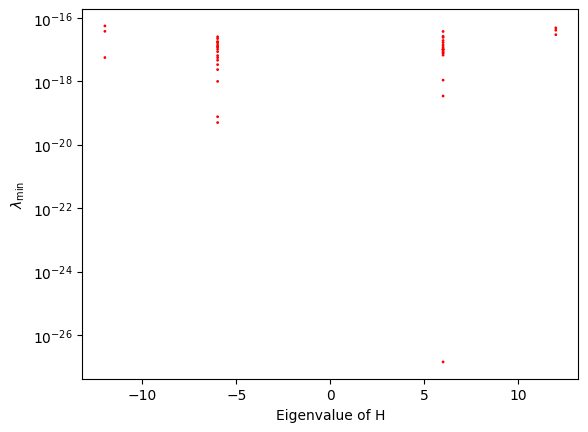

Indices of red points: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41]
0 0
Eigenvalue: -12.000000000000002, rdm Minimum Eigenvalue: -5.609566569760965e-18
Eigenvector 0: rdm rank: 16
1 1
Eigenvalue: -12.000000000000002, rdm Minimum Eigenvalue: -3.7687193134264816e-17
Eigenvector 1: rdm rank: 16
2 2
Eigenvalue: -12.0, rdm Minimum Eigenvalue: -5.57041943577709e-17
Eigenvector 2: rdm rank: 16
3 3
Eigenvalue: -6.000000000000005, rdm Minimum Eigenvalue: -1.4057864764840046e-17
Eigenvector 3: rdm rank: 28
4 4
Eigenvalue: -6.000000000000005, rdm Minimum Eigenvalue: -6.4582407369901466e-18
Eigenvector 4: rdm rank: 28
5 5
Eigenvalue: -6.000000000000004, rdm Minimum Eigenvalue: -1.6837695512344243e-17
Eigenvector 5: rdm rank: 28
6 6
Eigenvalue: -6.000000000000004, rdm Minimum Eigenvalue: -8.607400855681927e-18
Eigenvector 6: rdm rank: 28
7 7
Eigenvalue: -6.000000000000002, rdm Minimum E

In [14]:
# rdm - numpy

min_eigenvalues_np = []
min_rdms_np =[]
rdm_eigenvalues_np = []
red_indices = sparse_indices
red_eigenvalues = [eigenvalues[i] for i in red_indices]

for i in tqdm(red_indices):
    # Construct the density matrix for each eigenvector
    min_eigenvector = eigenvectors[:, i]
    density_matrix = np.outer(min_eigenvector, min_eigenvector.conj())

    # Trace out qubits
    traced_out_density_matrix = ptrace_numpy(density_matrix, keep_qubits, [[2]*N, [2]*N])

    # Diagonalize the traced-out density matrix
    eigenvalues_traced, eigenvectors_traced = np.linalg.eigh(traced_out_density_matrix)

    # Find the minimum eigenvalue of the traced-out density matrix
    min_eigenvalue = np.min(eigenvalues_traced) 
    min_eigenvalues_np.append(min_eigenvalue)

    if min_eigenvalue < 1e-16:
        min_rdms_np.append(traced_out_density_matrix) #store the scarred rdms - step needed for optimization
        rdm_eigenvalues_np.append(eigenvalues_traced) #store the eigenvalues of the scarred rdms

# numpy

# Define the threshold
threshold = 1e-16
min_eigenvalues_np = np.array(min_eigenvalues_np)

# Count points with y-component less than the threshold
count = sum(1 for y in min_eigenvalues_np if y < threshold)

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'C0' for y in min_eigenvalues_np]

# Plot the minimum eigenvalue of the traced-out density matrix as a function of the eigenvalue of the Hamiltonian H
plt.scatter(red_eigenvalues, np.abs(min_eigenvalues_np), color=colors, s=1)

plt.xlabel('Eigenvalue of H')
plt.ylabel(r"$\lambda_{\text{min}}$")
plt.yscale("log")
plt.show()

# Find indices of red points - numpy
red_indices_np = [i for i, y in enumerate(min_eigenvalues_np) if y < threshold]
print(f'Indices of red points: {red_indices_np}')

red_eigenvectors_np = []

# Print eigenvalues, RDM minimum eigenvalues, and scalar products of eigenvectors for red points
for i,ind in enumerate(red_indices_np):
    print(i, ind)
    print(f'Eigenvalue: {red_eigenvalues[ind]}, rdm Minimum Eigenvalue: {min_eigenvalues_np[ind]}')
    print(f'Eigenvector {ind}: rdm rank: {np.linalg.matrix_rank(min_rdms_np[i])}')
    red_eigenvectors_np.append(eigenvectors[:, ind])

#for i in range(len(red_indices_np)):
#    for j in range(len(red_indices_np)):
#        idx1, idx2 = red_indices_np[i], red_indices_np[j]
#        dot_product = np.dot(eigenvectors[:, idx1], np.conj(eigenvectors[:, idx2]))
#        print(f"Dot product between eigenvectors {idx1} and {idx2}: {dot_product}")


In [13]:
half = [0,1,4,6,8,11,13] #7 qubits
# Print selected eigenvalues in red
selected_indices = red_indices
for idx in selected_indices:
    print(f"\033[91mEigenvalue[{idx}] = {eigenvalues[idx]}\033[0m")

Eigenvalue[2736] = -12.0
Eigenvalue[2737] = -12.0
Eigenvalue[2738] = -12.0
Eigenvalue[5157] = -6.000000000000007
Eigenvalue[5158] = -6.000000000000005
Eigenvalue[5159] = -6.000000000000002
Eigenvalue[5160] = -6.000000000000001
Eigenvalue[5161] = -6.000000000000001
Eigenvalue[5162] = -6.000000000000001
Eigenvalue[5163] = -6.000000000000001
Eigenvalue[5164] = -6.000000000000001
Eigenvalue[5165] = -6.0
Eigenvalue[5166] = -6.0
Eigenvalue[5167] = -6.0
Eigenvalue[5168] = -6.0
Eigenvalue[5169] = -6.0
Eigenvalue[5170] = -6.0
Eigenvalue[5171] = -5.999999999999998
Eigenvalue[5172] = -5.999999999999997
Eigenvalue[5173] = -5.9999999999999964
Eigenvalue[5174] = -5.999999999999993
Eigenvalue[11209] = 5.999999999999994
Eigenvalue[11210] = 5.999999999999995
Eigenvalue[11211] = 5.999999999999997
Eigenvalue[11212] = 5.999999999999998
Eigenvalue[11213] = 5.999999999999998
Eigenvalue[11214] = 5.999999999999998
Eigenvalue[11215] = 6.0
Eigenvalue[11216] = 6.0
Eigenvalue[11217] = 6.0
Eigenvalue[11218] = 6.0


In [14]:
# Compute bipartite entanglement entropy for all eigenstates in the full Hilbert space
numpy_entropies = [entanglement_entropy(eigenvectors[:, i], half, N) for i in tqdm(range(len(eigenvalues)))]
#qutip_entropies = [entanglement_entropy_qutip(eigenvectors[:, i], half, N) for i in tqdm(range(eigenvectors.shape[1]))]
#torch_entropies = [entanglement_entropy_torch(eigenvectors[:, i], half, N) for i in tqdm(range(eigenvectors.shape[1]))]

100%|██████████| 16384/16384 [21:42:52<00:00,  4.77s/it]   


Entropies of red points:
Index: 2736, Entropy: 0.21765407113037055
Index: 2737, Entropy: 0.011589983795718708
Index: 2738, Entropy: 4.993741520169728
Index: 5157, Entropy: 3.681696536555698
Index: 5158, Entropy: 4.196839598557818
Index: 5159, Entropy: 2.7994655152442083
Index: 5160, Entropy: 3.9882690857246335
Index: 5161, Entropy: 4.332819581345279
Index: 5162, Entropy: 3.1555235975636964
Index: 5163, Entropy: 4.710583192594125
Index: 5164, Entropy: 4.3791263477442675
Index: 5165, Entropy: 5.062845706715116
Index: 5166, Entropy: 4.577185050696878
Index: 5167, Entropy: 4.291064179031219
Index: 5168, Entropy: 3.363816774657658
Index: 5169, Entropy: 4.511309865819683
Index: 5170, Entropy: 3.4199721288559006
Index: 5171, Entropy: 4.016034355389245
Index: 5172, Entropy: 4.553001811445874
Index: 5173, Entropy: 3.5678464750325594
Index: 5174, Entropy: 3.968512128547135
Index: 11209, Entropy: 3.8151566930557954
Index: 11210, Entropy: 3.8402887949592075
Index: 11211, Entropy: 4.832131111536984

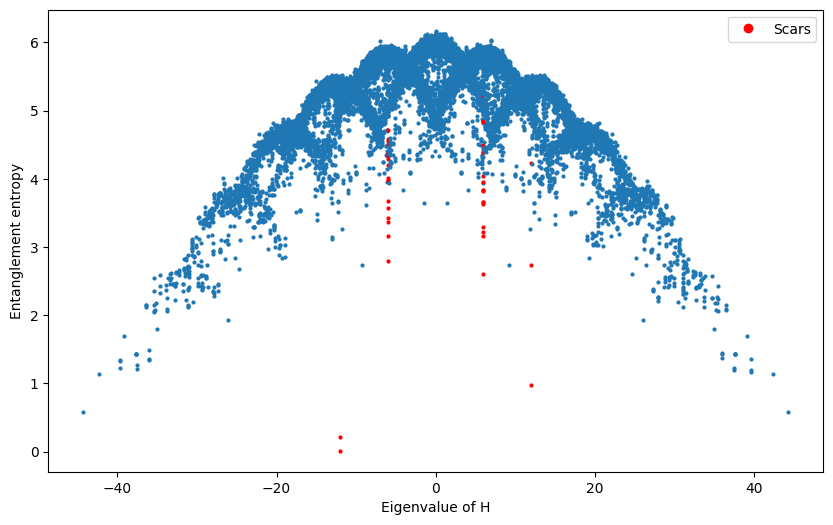

In [15]:
# Print entropies of red points only
print("Entropies of red points:")
red_entropies = [numpy_entropies[i] for i in red_indices]
for i in selected_indices:
    print(f'Index: {i}, Entropy: {numpy_entropies[i]}')

# Plot entanglement entropy as a function of energy eigenvalues
plt.figure(figsize=(10, 6))

# Highlight points with y-component less than the threshold in red
colors = ['red' if y in red_entropies else 'C0' for y in numpy_entropies]

# Plot entanglement entropy with highlighted points
for i, color in enumerate(colors):
    plt.plot(eigenvalues[i], numpy_entropies[i], 'o', color=color, markersize=2)

# Add legend for red points only with text "scars"
red_points = [i for i, color in enumerate(colors) if color == 'red']
if red_points:
    plt.plot([], [], 'o', color='red', label='Scars')

plt.xlabel('Eigenvalue of H')
plt.ylabel('Entanglement entropy')
plt.legend()
plt.show()

In [ ]:
################## PROPERTIES OF EACH SCARRED STATE AND THEIR RDM ######################

In [ ]:
# List to store the number of dependent columns and their indices for each matrix
dependent_columns_info = []

for idx, rdm in enumerate(min_rdms_np):
    print(f"RDM Index: {idx}")
    
    # Perform QR decomposition with column pivoting
    Q, R, pivot_indices = qr(rdm, pivoting=True)
    
    # Determine rank using a threshold on the diagonal of R
    tol = 1e-12
    rank = np.sum(np.abs(np.diag(R)) > tol)
    
    # Calculate the number of dependent columns
    num_dependent_columns = 16 - rank
    
    # Identify dependent columns
    dependent_columns = sorted(set(range(16)) - set(pivot_indices[:rank]))
    dependent_columns_info.append((num_dependent_columns, dependent_columns))
    
    print(f"Number of dependent columns: {num_dependent_columns}")
    print(f"Dependent columns indices: {dependent_columns}")
    print("-" * 50)

# Print the results
print("Dependent columns info for each matrix:", dependent_columns_info)

In [ ]:
# List to store the null space information for each matrix
null_spaces_info = []

for idx, rdm in enumerate(min_rdms_np):
    print(f"RDM Index: {idx}")
    
    # Compute the null space of the RDM
    null_space_rdm = null_space(rdm)
    
    # Store the null space information
    null_spaces_info.append(null_space_rdm)
    
    # Print the null space dimensions and basis vectors
    print(f"Null space dimension: {null_space_rdm.shape[1]}")
    print(f"Null space basis vectors:\n{null_space_rdm}")
    print("-" * 50)

    # Apply the RDM to each null basis vector
    for i, basis_vector in enumerate(null_space_rdm.T):  # Transpose to iterate over columns
        result = np.dot(rdm, basis_vector)
        print(f"RDM {idx}, Null Basis Vector {i}:")
        print(f"Result: {result}")
        print(f"Norm of Result: {np.linalg.norm(result)}")

# Print the results
print("Null space information for each matrix computed.")

In [ ]:
# For each RDM, check if any row in its null space basis matrix is (close to) zero
for idx, rdm in enumerate(min_rdms_np):
    null_space_rdm = null_space(rdm)
    for i, row in enumerate(null_space_rdm):
        if np.allclose(row, 0, atol=1e-12):
            print(f"RDM {idx}: Row {i} in null space is (close to) zero.")

In [ ]:
# Count the number of distinct rows in the null space basis of RDM 0
rdm = min_rdms_np[4]
null_space_rdm = null_space(rdm)

# Use np.allclose to group rows that are numerically identical
distinct_rows = []
for i, row in enumerate(null_space_rdm):
    is_new = True
    for drow in distinct_rows:
        if np.allclose(row, drow, atol=1e-12):
            is_new = False
            break
    if is_new:
        distinct_rows.append(row)

print(f"Number of distinct rows in null space basis of RDM 0: {len(distinct_rows)}")

In [ ]:
# Print the binary basis states for each group of identical rows in the null space basis of RDM 0 (5 spins)
# Also print the smallest row index for each group

def index_to_binary(index, num_qubits):
    return format(index, f'0{num_qubits}b')

rdm = min_rdms_np[0]
null_space_rdm = null_space(rdm)

# Group row indices by their unique row (up to numerical tolerance)
groups = []
group_indices = []

for i, row in enumerate(null_space_rdm):
    found = False
    for g, grow in enumerate(groups):
        if np.allclose(row, grow, atol=1e-12):
            group_indices[g].append(i)
            found = True
            break
    if not found:
        groups.append(row)
        group_indices.append([i])

print(f"Number of distinct rows: {len(groups)}")
for indices in group_indices:
    basis_states = [index_to_binary(idx, 5) for idx in indices]
    min_row = min(indices)
    print(f"Row {min_row}: Basis states: {', '.join(basis_states)}")

In [ ]:
# List to store the null space information for each matrix
null_spaces_info = []

for idx, rdm in enumerate(min_rdms_np):
    print(f"RDM Index: {idx}")
    
    # Compute the null space of the RDM
    null_space_rdm = null_space(rdm)
    
    # Store the null space information
    null_spaces_info.append(null_space_rdm)
    
    # Print the null space dimensions and basis vectors
    print(f"Null space dimension: {null_space_rdm.shape[1]}")
    #print(f"Null space basis vectors:\n{null_space_rdm}")
    print("-" * 50)

    # Apply the RDM to each null basis vector
    #for i, basis_vector in enumerate(null_space_rdm.T):  # Transpose to iterate over columns
        #result = np.dot(rdm, basis_vector)
        #print(f"RDM {idx}, Null Basis Vector {i}:")
        #print(f"Result: {result}")
        #print(f"Norm of Result: {np.linalg.norm(result)}")
    
    # Check for repeating rows in the null space basis vectors
    print(f"Repeating rows in the null space basis vectors for RDM {idx}:")
    for i in range(null_space_rdm.shape[0]):
        for j in range(i + 1, null_space_rdm.shape[0]):
            if np.allclose(null_space_rdm[i, :], null_space_rdm[j, :], atol=1e-12):  # Compare rows with a tolerance
                print(f"Row {i} is identical to Row {j}")
    print("-" * 50)

In [ ]:
# Iterate over scarred eigenvectors
for i, eigenvector in enumerate(red_eigenvectors_np):
    # Print the entire eigenvector
    non_zero_count = 0  # Counter for non-zero components
    print(f"Full Eigenvector {i}:")
    for index, component in enumerate(eigenvector):
        # Set components of the order 10^-12 or smaller to zero
        if np.abs(component) < 1e-12: # I noticed that  most components are of the order 10^-13 or smaller - only a handful are mucgh larger
            eigenvector[index] = 0.0
        else:
            non_zero_count += 1
        binary_basis = index_to_binary(index, N)
        print(f"{binary_basis}: {eigenvector[index]}")

    print(f"Total Non-Zero Components in Scarred Eigenvector {i}: {non_zero_count}")
    print("=" * 50)

In [ ]:
# Iterate over scarred eigenvectors
for i, eigenvector in enumerate(red_eigenvectors_np):
    print(f"Scarred Eigenvector {i}:")
    
    # Dictionary to track processed coefficients
    processed_coeffs = set()
    
    # Iterate over components of the eigenvector
    for index, component in enumerate(eigenvector):
        if np.abs(component) > 1e-12:  # Check if the component is non-zero
            binary_basis = index_to_binary(index, N)
            coeff = component
            
            # Skip if this coefficient (or its negative) has already been processed
            if coeff in processed_coeffs or -coeff in processed_coeffs:
                continue
            
            # Count the number of 1's in the binary representation
            num_ones = binary_basis.count('1')
            
            # Print the coefficient, binary representation, and number of 1's
            print(f"  Coefficient: {coeff}")
            print(f"    Binary Representation: {binary_basis}")
            print(f"    Elements [0, 4, 5, 9]: {binary_basis[0]}, {binary_basis[4]}, {binary_basis[5]}, {binary_basis[9]}")
            print(f"    Number of 1's: {num_ones}")
            
            # Check for the negative of the coefficient
            for j, other_component in enumerate(eigenvector):
                if np.abs(other_component + coeff) < 1e-10:  # Compare with tolerance
                    binary_basis_neg = index_to_binary(j, N)
                    num_ones_neg = binary_basis_neg.count('1')
                    print(f"  Negative Coefficient: {-coeff}")
                    print(f"    Binary Representation: {binary_basis_neg}")
                    print(f"    Elements [0, 4, 5, 9]: {binary_basis_neg[0]}, {binary_basis_neg[4]}, {binary_basis_neg[5]}, {binary_basis_neg[9]}")
                    print(f"    Number of 1's: {num_ones_neg}")
                    break
            
            # Mark this coefficient and its negative as processed
            processed_coeffs.add(coeff)
            processed_coeffs.add(-coeff)
    
    print("=" * 50)

In [ ]:
# List to store even swaps numbers
even_swaps_numbers = []

# Dictionary to track spin exchange arrays and their counts
spin_exchange_counts = {}

# Iterate over scarred eigenvectors
for i, eigenvector in enumerate(red_eigenvectors_np):
    print(f"Scarred Eigenvector {i}:")

    # Dictionary to track processed coefficients
    processed_coeffs = set()

    # Iterate over components of the eigenvector
    for index, component in enumerate(eigenvector):
        if np.abs(component) > 1e-12:  # Check if the component is non-zero
            binary_basis = index_to_binary(index, N)
            coeff = component

            # Skip if this coefficient (or its negative) has already been processed
            if coeff in processed_coeffs or -coeff in processed_coeffs:
                continue

            # Check for the negative of the coefficient
            for j, other_component in enumerate(eigenvector):
                if np.abs(other_component + coeff) < 1e-10:  # Compare with tolerance
                    binary_basis_neg = index_to_binary(j, N)

                    # Identify the spins that are exchanged
                    spin_exchange = [
                        k for k in range(N) if binary_basis[k] != binary_basis_neg[k]
                    ]

                    # Compute swaps number
                    swaps_number = len(spin_exchange) // 2

                    # Check if swaps number is odd
                    is_odd = swaps_number % 2 == 1

                    print(f"  Coefficient: {coeff}")
                    print(f"    Binary Representation: {binary_basis}")
                    print(f"  Negative Coefficient: {-coeff}")
                    print(f"    Binary Representation: {binary_basis_neg}")
                    print(f"    Spin Exchange: {spin_exchange}")
                    print(f"    Swaps Number: {swaps_number} (Odd: {is_odd})")

                    # Add to even swaps numbers if swaps number is even
                    if not is_odd:
                        even_swaps_numbers.append(swaps_number)

                    # Track spin exchange arrays
                    spin_exchange_tuple = tuple(spin_exchange)
                    if spin_exchange_tuple in spin_exchange_counts:
                        spin_exchange_counts[spin_exchange_tuple] += 1
                    else:
                        spin_exchange_counts[spin_exchange_tuple] = 1

                    break

            # Mark this coefficient and its negative as processed
            processed_coeffs.add(coeff)
            processed_coeffs.add(-coeff)

    print("=" * 50)

# Print the list of even swaps numbers
print("Even swaps numbers:", even_swaps_numbers)

# Check for repeated spin exchange arrays
repeated_spin_exchanges = [
    spin_exchange for spin_exchange, count in spin_exchange_counts.items() if count > 1
]
if repeated_spin_exchanges:
    print("Repeated spin exchange arrays:", repeated_spin_exchanges)
else:
    print("No repeated spin exchange arrays found.")

print(len(spin_exchange_counts), "spin exchange arrays found.")

In [ ]:
# min_scar

non_zero_count = 0  # Counter for non-zero components

for index, component in enumerate(min_scar):
    # Set components of the order 10^-12 or smaller to zero
    if np.abs(component) < 1e-12: # I noticed that  most components are of the order 10^-13 or smaller - only a handful are mucgh larger
        min_scar[index] = 0.0
    else:
        non_zero_count += 1
    binary_basis = index_to_binary(index, N)
    print(f"{binary_basis}: {np.real(min_scar[index])}")

print(f"Total Non-Zero Components in min_scar: {non_zero_count}")
print("=" * 50)

In [ ]:
# check if other states have 280 non-zero components - it's only the 5 scars!

# Count distinct non_zero_count values
distinct_counts = set()

# Counter to track occurrences of each non_zero_count
non_zero_count_occurrences = Counter()

# Iterate over all eigenvectors
for i in range(eigenvectors.shape[1]):
    eigenvector = eigenvectors[:, i]
    non_zero_count = 0  # Counter for non-zero components
    
    # Count non-zero components
    for component in eigenvector:
        if np.abs(component) >= 1e-12:
            non_zero_count += 1
    
    # Update the counter
    non_zero_count_occurrences[non_zero_count] += 1
    print(f"Total Non-Zero Components in Eigenvector {i}: {non_zero_count}")

# Print the number of distinct non_zero_count values
print(f"Number of distinct non_zero_count values: {len(non_zero_count_occurrences)}")
print(f"Distinct non_zero_count values: {sorted(non_zero_count_occurrences.keys())}")

# Print how many times each distinct non_zero_count appears
print("Occurrences of each non_zero_count:")
for count, occurrences in sorted(non_zero_count_occurrences.items()):
    print(f"Non-Zero Count: {count}, Occurrences: {occurrences}")